# Niave Composite Solve

This script will attempt to solve the system of equations on the composite medium (dielectric plus dielectic inclusions) for the cross-in-plane geometry example.
The domain is $\Omega = \left[0,1\right]^2$ with periodic boundary conditions.
The quasi-momentum $\theta$ is fixed for each problem.
The singular inclusions are the quantum graph $\mathbb{G}$ which consists of vertices and edges
\begin{align*}
    v_1 = (0.5,1.0), \quad v_2 = (0.0,0.5), \quad v_3 &= (0.5,0.5), \quad v_4 = (1.0,0.5), \quad v_5 = (0.5,0.0), \\
    l_{23} = l_{34} = & l_{53} = l_{31} = 0.5, \\
    \theta_{23} = \theta_{34} = \theta_1, &\quad \theta_{53} = \theta_{31} = \theta_2.
\end{align*}
The graph divides $\Omega$ into four regions (although in reality it's only one region by the periodic BCs) which we label $\Omega_i$ for $i=1,2,3,4$; ordered counterclockwise as 1 (bottom left), 2 (top left), 3 (top right) and 4 (bottom right).

This will be done through a niave finite-difference approximation to the operator that acts on each part of the domain.
The equations to solve are:
\begin{align*}
    -\Delta_{\theta}u &= -\omega^2 u, \qquad x\in\Omega_i, \\
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} &= \omega^2 u_{jk} + \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right), \qquad x\in I_{jk}, \\
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3.
\end{align*}
__NOTE:__ We haven't done the analysis for when $\alpha_j\neq0$ for the composite measure.
The domain is also subject to the periodic boundary conditions $u(0,y) = u(1,y)$ and $u(x,0) = u(x,1)$.

We must first discretise our domain into a (for ease, uniform) $N\times N$ grid.
Since we _need_ meshpoints on the graph itself, it will be convenient for us to take $N$ odd, so that the points can be generated via `linspace`.
Set $h = \frac{1}{N-1}$ as the mesh width, and for each $i,j\in\{0,...,N-1\}$ we define $u_{i,j} = u(ih, jh)$.
We must now discretise our operators, after which we find that
\begin{align*}
    -\Delta_{\theta}u_{i,j} &\approx
    \lvert\theta\rvert^2 u_{i,j} 
    - 2\mathrm{i}h^{-1}\left[ \theta_1\left( u_{i-1,j} + u_{i+1,j} - 2u_{i,j} \right) + \theta_2\left( u_{i,j-1} + u_{i,j+1} - 2u_{i,j} \right) \right]
    + h^{-2}\left[ 4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} \right], \\
    &= \left(\lvert\theta\rvert^2 + 4\mathrm{i}h^{-1}(\theta_1+\theta_2) + 4h^{-2}\right)u_{i,j}
    - \left(2\mathrm{i}h^{-1}\theta_1 + h^{-2} \right)(u_{i-1,j} + u_{i+1,j})
    - \left(2\mathrm{i}h^{-1}\theta_2 + h^{-2} \right)(u_{i,j-1} + u_{i,j-1})
\end{align*}
in any region $\Omega_i$.
For horizontal edges ($I_{23}$ and $I_{34}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i-1,j} - u_{i+1,j} \right) - h^{-1}\left[ u_{i,j+1} - u_{i,j-1} - 2\mathrm{i}\theta_{jk}\left(u_{i+1,j} - u_{i,j} \right) \right],
\end{align*}
whilst for vertical edges ($I_{53}$ and $I_{31}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i,j-1} - u_{i,j+1} \right) - h^{-1}\left[ u_{i+1,j} - u_{i-1,j} - 2\mathrm{i}\theta_{jk}\left(u_{i,j+1} - u_{i,j} \right) \right].
\end{align*}
Note the interaction between of the regions either side of an edge as $\Omega^+$ and $\Omega^-$ are chosen in the derivation document ($\Omega^+$ is in the positive $n_{jk}$ direction off $I_{jk}$), combined with how our gridpoints are labelled ($i,j$ increase up and to the right respectively).
Finally, at $v_3$ it is best if we explicitly write down what the sum reduces to:
\begin{align*}
    0 &= h^{-1}\left( u_{i-1,j} - u_{i+1,j} + u_{i,j-1} - u_{i,j+1} \right)
\end{align*}

It is now time to assemble the Finite Difference Matrix (FDM) for the problem above.
We need to take into account the fact that we want to force adherence to periodic boundary conditions, so we build a $(N-1)\times(N-1)$ FDM, shaving off the "slave" boundaries $u(1,y)$ and $u(x,1)$ - we will reconstruct these from the solution.
This means that we only need to solve for the gridpoint values $u_{i,j}$ for $i,j\in\{0,...,N-2\}$, however also means that we need to remember that the value "to the left" of $u_{0,j}$ is $u_{N-2,j}$ for example, and similarly for the other boundaries.
We'll also have to do some array manipulation to insert the "slave" gridpoint values back int our solution for plotting and visualisation too.

We will elect to store the points $u_{i,j}$ column-wise, so we acquire a vector
\begin{align*}
    U = \begin{pmatrix} u_{0,0} \\ u_{0,1} \\ \vdots \\ u_{0,N-2} \\ u_{1,0} \\ u_{1,1} \\ \vdots \end{pmatrix},
\end{align*}
and running `U.resize((N-1,N-1))` will then produce an $(N-1)\times(N-1)$ matrix whose $ij$-th entry is $u_{i,j}$.
The following "translation" between the column vector and grid representation of the solution holds with the above setup;
\begin{align*}
    u_{i,j} = U[j + (N-1)i],
\end{align*}
for any $i,j\in\{0,...,N-2\}$.

In [1]:
# imports
import numpy as np
from numpy.random import choice
from scipy.linalg import eig

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# number of meshpoints
# this is defined up here to save an argument being passed to M2C every time we want to use it
N = 31
if N%2==0:
    print('N = %d is not even, using N=%d instead' % (N, N+1))
    N += 1
# mesh width
h = 1./(N-1)

# gridpoint placements
x = y = np.linspace(0.,1.,num=N)

# basic functions
def M2C(i,j):
    '''
    Provides the column index in U for the gridpoint u_{i,j}.
    INPUTS:
        i,j: int, gridpoint indices
    OUTPUTS:
        c: int, index such that U[c] = u_{i,j}
    '''
    
    return j + (N-1)*i

## Assembling the FDM

`X[N//2]` = `Y[N//2]` $=0.5$ exactly, and thus identify the meshpoints which lie on the graph (`x` and `y` also have this point equal to $0.5$ as well).
The meshpoints which fall into each region $\Omega_i$ are now easily collected:
- $\Omega_1$ (bottom left) `X[:N//2]` and `Y[:N//2]`. That is, $i=0,...,N//2-1$ and $j=0,...,N//2-1$.
- $\Omega_2$ (top left) `X[:N//2]` and `Y[N//2+1:]`. That is, $i=0,...,N//2-1$ and $j=1+N//2,...,N-2$.
- $\Omega_3$ (top right) `X[N//2+1:]` and `Y[N//2+1:]`. That is, $i=1+N//2,...,N-2$ and $j1+N//2,...,N-2$.
- $\Omega_4$ (bottom right) `X[N//2+1:]` and `Y[:N//2]`. That is, $1+N//2,...,N-2$ and $j=0,...,N//2-1$.

The graph edges are also easily collated now:
- $I_{31}$: `X[N//2]` and `Y[N//2+1:]`,
- $I_{53}$: `X[N//2]` and `Y[:N//2]`,
- $I_{23}$: `X[:N//2]` and `Y[N//2]`,
- $I_{34}$: `X[N//2+1:]` and `Y[N//2]`,

and of course, $v_3$ lies at `X[N//2],Y[N//2]`.

For a gridpoint $i,j$ in one of the regions $\Omega_i$, we now build the FDM rows that correspond to the equation at that gridpoint.
Recall that
\begin{align*}
    -\Delta_{\theta}u_{i,j} &\approx
    \left(\lvert\theta\rvert^2 + 4\mathrm{i}h^{-1}(\theta_1+\theta_2) + 4h^{-2}\right)u_{i,j}
    - \left(2\mathrm{i}h^{-1}\theta_1 + h^{-2} \right)(u_{i-1,j} + u_{i+1,j})
    - \left(2\mathrm{i}h^{-1}\theta_2 + h^{-2} \right)(u_{i,j-1} + u_{i,j-1})
\end{align*}

In [2]:
def RegionalFDM(M, region, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j in the region Omega_region.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        region: int, 1-4 specifying which region to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the region Omega_region will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    # Compute some common constants first
    h = 1./(N-1)
    sqMagTheta = theta[0]*theta[0] + theta[1]*theta[1]
    sumTheta = np.sum(theta)
    
    # determine correct indices to loop over via lookup
    if region==1:
        jR = range(N//2)
        iR = range(N//2)
    elif region==2:
        jR = range(1+N//2,N-1)
        iR = range(N//2)
    elif region==3:
        jR = range(1+N//2,N-1)
        iR = range(1+N//2,N-1)
    elif region==4:
        jR = range(N//2)
        iR = range(1+N//2,N-1)
    else:
        raise ValueError('Unrecognised region, got %d' % (region))
        
    # now insert the entries of the FDM for the given region
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for j in jR:
            for i in iR:
                # this is the row that we are going to set
                Mrow = M2C(i,j)
                # u_{i,j} prefactor is placed on the diagonal
                M[Mrow, Mrow] = sqMagTheta + 4.j*sumTheta/h + 4/(h*h)
                # now place u_{i-1,j} and u_{i+1,j} prefactors
                # take index modulo N, since if you're on the periodic boundary you need to 
                # loop to the other side of the domain
                iLeft = (i-1) % (N-1)
                iRight = (i+1) % (N-1)
                leftIndex = M2C(iLeft, j)
                rightIndex = M2C(iRight, j)
                M[Mrow, leftIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                M[Mrow, rightIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
                jUp = (j+1) % (N-1)
                jDown = (j-1) % (N-1)
                upIndex = M2C(i,jUp)
                downIndex = M2C(i,jDown)
                M[Mrow, upIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                M[Mrow, downIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                # this completes the construction of this row of the FDM, we now have that
                # FDM[Mrow,:] * U[Mrow] defines the expression for -\Laplacian_{\theta} at i,j.
                print('---')
                print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
                print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished region: %d' % (region))
    else:
        for j in jR:
            for i in iR:
                Mrow = M2C(i,j)
                M[Mrow, Mrow] = sqMagTheta + 4.j*sumTheta/h + 4/(h*h)
                
                iLeft = (i-1) % (N-1)
                iRight = (i+1) % (N-1)
                leftIndex = M2C(iLeft, j)
                rightIndex = M2C(iRight, j)
                M[Mrow, leftIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                M[Mrow, rightIndex] = - ( 2.j*theta[0]/h + 1./(h*h) )
                
                jUp = (j+1) % (N-1)
                jDown = (j-1) % (N-1)
                upIndex = M2C(i,jUp)
                downIndex = M2C(i,jDown)
                M[Mrow, upIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
                M[Mrow, downIndex] = - ( 2.j*theta[1]/h + 1./(h*h) )
    return

For horizontal edges ($I_{23}$ and $I_{34}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_1 \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i-1,j} - u_{i+1,j} \right) - h^{-1}\left[ u_{i,j+1} - u_{i,j-1} - 2\mathrm{i}\theta_1\left(u_{i+1,j} - u_{i,j} \right) \right],
\end{align*}
since $\theta_{jk}=\theta_1$ on horizontal edges.
For ease, we can rearrange this to be
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_1 \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    2h^{-1}(h^{-1}-\mathrm{i}\theta_1)u_{i,j} 
    - h^{-2}u_{i-1,j}
    + h^{-1}(2\mathrm{i}\theta_1 - h^{-1})u_{i+1,j}
    - h^{-1}u_{i,j+1}
    + h^{-1}u_{i,j-1}
\end{align*}
We can now construct the rows of the FDM corresponding to the horizontal edges.

In [3]:
def HorEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 23 or 34, specifying which horizontal edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./(N-1)
    # setup loop ranges based on the edge we are working on
    if edge==23:
        iR = range(N//2)
    elif edge==34:
        iR = range(1+N//2,N-1)
    else:
        raise ValueError('Unknown horizontal edge, got %d' % (edge))
    j = N//2 # j is constant for horizontal edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for i in iR:
            # get row index
            Mrow = M2C(i,j)
            # u_{i,j} prefactor is placed on the diagonal
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[0])
            # now place u_{i-1,j} and u_{i+1,j} prefactors
            # take index modulo N, since if you're on the periodic boundary you need to 
            # loop to the other side of the domain
            iLeft = (i-1) % (N-1)
            iRight = (i+1) % (N-1)
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = - 1./(h*h)
            M[Mrow, rightIndex] = - 1./(h*h) + 2.j*theta[0]/h
            # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
            jUp = (j+1) % (N-1)
            jDown = (j-1) % (N-1)
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = -1./h
            M[Mrow, downIndex] = 1./h
            # this completes the construction of this row of the FDM, we now have that
            # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished edge: I_%d' % (edge))
    else:
        for i in iR:
            Mrow = M2C(i,j)
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[0])
            
            iLeft = (i-1) % (N-1)
            iRight = (i+1) % (N-1)
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = - 1./(h*h)
            M[Mrow, rightIndex] = - 1./(h*h) + 2.j*theta[0]/h
            
            jUp = (j+1) % (N-1)
            jDown = (j-1) % (N-1)
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = -1./h
            M[Mrow, downIndex] = 1./h      
    return

For the vertical edges ($I_{53}$ and $I_{31}$) we have that
\begin{align*}
    -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    h^{-2}\left( 2u_{i,j} - u_{i,j-1} - u_{i,j+1} \right) - h^{-1}\left[ u_{i+1,j} - u_{i-1,j} - 2\mathrm{i}\theta_{jk}\left(u_{i,j+1} - u_{i,j} \right) \right],
\end{align*}
which we can re-write as
\begin{align*}
        -\left(\dfrac{\mathrm{d}}{\mathrm{d}y} + \mathrm{i}\theta_{jk} \right)^2 u_{jk} - \dfrac{\partial}{\partial n_{jk}}\left(u^+ - u^-\right)
    &\approx
    2h^{-1}(h^{-1} - \mathrm{i}\theta_2)u_{i,j}
    - h^{-2}u_{i,j-1}
    + h^{-1}(2\mathrm{i}\theta_2 - h^{-1})u_{i,j+1}
    - h^{-1}u_{i+1,j}
    + h^{-1}u_{i-1,j}.
\end{align*}

In [4]:
def VerEdgeFDM(M, edge, N, theta, log=False):
    '''
    Construct the FDM rows that correspond to gridpoints i,j on the edge I_{edge}
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written
        edge: int, either 31 or 53, specifying which vertical edge to construct the rows for
        N: int, number of meshpoints in each dimension
        theta: (2,) float, the value of the quasi-momentum
    OUTPUTS:
        M: Rows associated with gridpoints in the edge I_{edge} will be populated with FDM entries. 
        Overwrites any values previously stored in entries that are to be edited.
    '''
    
    h = 1./(N-1)
    # setup loop ranges based on the edge we are working on
    if edge==53:
        jR = range(N//2)
    elif edge==31:
        jR = range(1+N//2,N-1)
    else:
        raise ValueError('Unknown vertical edge, got %d' % (edge))
    i = N//2 # i is constant for vertical edges
    
    # now insert the entries of the FDM for the given edge
    # The i + N*j th row of FDM contains the equation for the gridpoint u_{i,j}.
    if log:
        for j in jR:
            # get row index
            Mrow = M2C(i,j)
            # u_{i,j} prefactor is placed on the diagonal
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[1])
            # now place u_{i-1,j} and u_{i+1,j} prefactors
            # take index modulo N, since if you're on the periodic boundary you need to 
            # loop to the other side of the domain
            iLeft = (i-1) % (N-1)
            iRight = (i+1) % (N-1)
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = 1./h
            M[Mrow, rightIndex] = - 1./h
            # now place u_{i,j-1} and u_{i,j+1} prefactors, again accounting for periodic boundary
            jUp = (j+1) % (N-1)
            jDown = (j-1) % (N-1)
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = - 1./(h*h) + 2.j*theta[1]/h
            M[Mrow, downIndex] = -1./(h*h)
            # this completes the construction of this row of the FDM, we now have that
            # FDM[Mrow,:] * U[Mrow] defines the expression for the edge operator at i,j.
            print('---')
            print('Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
            print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
        print('Finished edge: I_%d' % (edge))
    else:
         for j in jR:
            Mrow = M2C(i,j)
            M[Mrow, Mrow] = 2./h *  (1./h - 1.j*theta[1])
            
            iLeft = (i-1) % (N-1)
            iRight = (i+1) % (N-1)
            leftIndex = M2C(iLeft, j)
            rightIndex = M2C(iRight, j)
            M[Mrow, leftIndex] = 1./h
            M[Mrow, rightIndex] = - 1./h
            
            jUp = (j+1) % (N-1)
            jDown = (j-1) % (N-1)
            upIndex = M2C(i, jUp)
            downIndex = M2C(i, jDown)
            M[Mrow, upIndex] = - 1./(h*h) + 2.j*theta[1]/h
            M[Mrow, downIndex] = -1./(h*h)
    return

For the gridpoint at $v_3$, which by definition is at position $(i,j)=(N//2,N//2)$, our FDM is already assuming continuity of the function here.
Instead, we shall encode the condition
\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk} &= \alpha_3\omega^2 u(v_3), \qquad x=v_3,
\end{align*}
here.
Again, we can put this into a nicer form for the FDM matrix, but also need to deal with what's happening with $\alpha_3$.
Moving $\alpha_3\neq 0$ to the LHS will ensure that the equation $\mathrm{FDM} U = \omega^2 U$ is still the discrete form of the original system --- leaving $\alpha_3$ with $\omega^2 u(v_3)$ would not represent a discrete version of this system.
This does mean there is a question to be had about what happens when $\alpha_3=0$ and how to properly discretise the system in this case.
I guess one would have to resort to a generalised eigenvalue solve, writing
\begin{align*}
    \left( \mathrm{FDM} - \beta\left(\omega^2\right) \right) U = 0,
\end{align*}
where $\beta(\omega^2)$ is just scalar multiplication by $\omega^2$ for every element save `M2C(N//2,N//2)`, which it zeros instead.

At any rate, we have that
\begin{align*}
    \sum_{j\sim k}\left(\dfrac{\partial}{\partial n} + \mathrm{i}\theta_{jk} \right)u_{jk}(v_3) &\approx
    h^{-1}\left( u_{i-1,j} - u_{i+1,j} + u_{i,j-1} - u_{i,j+1} \right).
\end{align*}
Note that this reduction is only true because of our symmetries; which cancel out the $\theta_{jk}u_{i,j}$ terms pairwise and give the normal derivatives a $\pm$ sign depending on the edge orientation.

In [5]:
def v3FDM(M, a3, N, tol=1e-8, log=True):
    '''
    Construct the FDM row that corresponds to the gridpoint at the vertex v_3.
    Different behaviour occurs for when alpha_3 = 0 and when it is non-zero.
    The input matrix M will be overwritten.
    INPUTS:
        M: (N*N,N*N) complex, the FDM into which the values for the rows will be written.
        a3: float, the value of the coupling constant alpha_3 at v_3.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        M: Row N//2+N*N//2 will be populated with FDM entries.
        Overwrites any values previously stored in entries that are to be edited.    
        
    If a3 = 0, then the row is assembled as discretised above.
    If a3 != 0, then the row is assembled with a 1/a3 prefactor in front of the discretisation above.
    '''
    
    h = 1./(N-1)
    # v_3 always lies at gridpoint (i,j) = (N//2, N//2)
    i = j = N//2
    Mrow = M2C(i,j)
    
    # determine indices that will be used for neighbouring points
    iLeft = (i-1) % (N-1)
    iRight = (i+1) % (N-1)
    jUp = (j+1) % (N-1)
    jDown = (j-1) % (N-1)
    leftIndex = M2C(iLeft, j)
    rightIndex = M2C(iRight, j)
    upIndex = M2C(i, jUp)
    downIndex = M2C(i, jDown)
    
    if log:
        print('---')
        print('[v3] Examined i,j = (%d,%d), Mrow = %d' % (i,j, Mrow))
        print('left: %d, right: %d, up: %d, down: %d' % (leftIndex, rightIndex, upIndex, downIndex))
    
    M[Mrow, leftIndex] = 1./h
    M[Mrow, rightIndex] = - 1./h
    M[Mrow, upIndex] = - 1./h
    M[Mrow, downIndex] = 1./h
    
    if np.abs(a3)<=tol:
        # alpha_3 is 0, notify user and construct LHS without alpha_3^-1 factor
        print('alpha_3 is zero: take care when solving discretised system.')
    else:
        print('alpha_3 non zero: assembling with prefactor 1/alpha_3 at v_3.')
        # rescale row by alpha_3
        M[Mrow,:] /= a3
    return

## Analysing the FDM

The matrix $M=$ `FDM` is our discretised form of the operator that defines our equations above.
The system
\begin{align*}
    M U = \omega^2 U,
\end{align*}
when $\alpha_3\neq 0$ is the discretised form of the above equation.
When $\alpha_3 = 0$, we have to use a trick to ensure that we are still solving this system and introduce the function $\beta(\omega^2)$ which is defined as

\begin{align*}
    \beta:\mathbb{C}\rightarrow\mathbb{C}^{(N-1)\times (N-1)},  \qquad
    \left( \beta(z) \right)_{jk} = (\delta_{j,k} - \delta_{N//2, N//2})z.
\end{align*}
Essentially, zero-out the entry corresponding to $u(v_3)$.
Also define $B = \beta(z)/z$ to be the constant matrix, which is just the identity matrix with 0 on the diagonal in the position corresponding to the vertex v_3.
Also, there is actually no reason for us to assume that the eigenvalues are entirely real (at least for the time being, since I don't know if the FDM is even Hermitian either), so using $z$ here makes more sense.
Then the system above is discretised into
\begin{align*}
    M U = \beta(z) U = z B U,
\end{align*}
which can be solved by a generalised eigenvalue solver.

In [6]:
def B(N):
    '''
    Constructs the matrix B defined above.
    INPUTS:
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        B: (N*N,N*N) complex, defined above.
    '''
    
    B = np.eye((N-1)*(N-1), dtype=complex)
    row = M2C(N//2, N//2)
    B[row, row] = 0. + 0.j
    return B

def Beta(z, N):
    '''
    Evaluates the matrix \beta defined above.
    Note that the argument is just z, so use the convention z = omega^2 here.
    INPUTS:
        z: complex, z=omega^2.
        N: int, number of meshpoints in each dimension.
    OUTPUTS:
        beta: (N*N,N*N) complex, defined above and evaluated at z.
    '''
    
    return z * B(N)

# This function is mainly a reality check to ensure that InsertSlaveNodes does it's job correctly.
def CheckPeriodicBCs(N, U, tol=1e-8):
    '''
    Given a solution vector for the Finite Difference approximation, check whether or not the
    solution satisfies the periodic boundary conditions at x=0 <-> x=N and y=0 <-> y=N.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: (N*N,) complex, solution vector to FDM approximation. Can also be of shape (N,N).
    OUTPUTS:
        tf: (2,) bool, True/False values depending on whether the periodic BCs are satisfied
    '''
    
    tf = np.array([True, True], dtype=bool)
    if U.ndim==1:
        # have been passed a column vector, need to reshape
        u = U.reshape((N,N))
    else:
        # should only have been passed a (N,N) array, so just copy this and use the values
        u = np.copy(U)
    uTB = u[N-1,:] - u[0,:]
    uLR = u[:,0] - u[:,N-1]
    tbMax = np.max(np.abs(uTB))
    lrMax = np.max(np.abs(uLR))
    
    if lrMax > tol:
        tf[0] = False
    if tbMax > tol:
        tf[1] = False
    
    return tf

def RealEvalIndices(wVals, tol=1e-8):
    '''
    Given the eigenvalues that our FDM approximation believes solve the discretised problem, extract only those
    which are entirely real (to a given tolerance).
    Return a boolian array tf such that wVals[tf] returns the array slice of only the real eigenvalues
    INPUTS:
        wVals: (n,) complex, eigenvalues from which to find entirely real values
        tol: (optional) float - default 1e-8, tolerance within which to accept imaginary part = 0
    OUTPUTS:
        tf: (n,) bool, wVals[tf] returns the array slice of only the real eigenvalues in wVals
    '''
    
    return np.abs(np.imag(wVals))<=tol

def Purge(vals):
    '''
    Given an array of complex values, remove any infs or NaN values in the array.
    INPUTS:
        vals: (n,) complex, array of values possibly containing infs or NaNs
    OUTPUTS:
        v: (m,) complex, array of values in v that are not inf or NaN
        tf: (n,) bool, vals[tf] = v
    '''
    
    tf = ((~ np.isnan(vals)) & (~ np.isinf(vals)))
    v = vals[tf]
    return v, tf

## Plotting and Solution Reconstruction Tools

The following functions enable us to take a solution to the FDM-approximation, re-insert the values on the "slave" boundary, and visualise the resulting (eigen)function.

In [7]:
def InsertSlaveNodes(N, U, mat=True):
    '''
    Given a (N-1)^2 solution vector U, insert the values at the periodic "slave" meshpoints to form a N*N matrix, 
    or (N*N) column vector
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: ((N-1)**2,) complex, column vector of eigenfunction values at (non-slave) meshpoints
        mat: bool - default True, if True, return an (N,N) matrix and otherwise return a (N*N,) column vector
    OUTPUTS:
        u: (N,N) or (N*N,) complex, representation of the solution U with "slave" gridpoint values appended
    '''

    # setup solution
    u = np.zeros((N,N), dtype=complex)
    # setup view of U to make life easier
    Uview = U.reshape((N-1,N-1))
    # copy values across, don't edit column vector U
    u[:N-1,:N-1] = Uview
    # insert missing "right boundary"
    u[N-1,:N-1] = np.copy(Uview[0,:])
    # insert missing "top boundary"
    u[:N-1,N-1] = np.copy(Uview[:,0])
    # insert point at (N-1,N-1) which has not yet been set
    u[N-1,N-1] = np.copy(u[0,0])
    if (not mat):
        u.resize((N*N,))
    
    return u

def PlotFn(N, U, levels=10):
    '''
    Create contour plots for the eigenfunction U that is passed in.
    INPUTS:
        N: int, number of meshpoints in each dimension
        U: ((N-1)**2,) complex, column vector of eigenfunction values at (non-slave) meshpoints
        levels: (optional) int - default 10, number of contour levels to pass to contourf.
    OUTPUTS:
        Two lists of the form [fig, ax] for the handles of the matplotlib figures,
        the first containing the plot of the real part of U and 
        the second containing the plot of the imaginary part of U.
    '''
    
    # gridpoints used
    x = y = np.linspace(0,1, num=N)
    # restore "slave" meshpoints
    u = InsertSlaveNodes(N, U, mat=True)
    # plot handles
    rFig, rAx = plt.subplots()
    iFig, iAx = plt.subplots()
    # axis setup
    for a in [rAx, iAx]:
        a.set_aspect('equal')
        a.set_xlabel(r'$x_1$')
        a.set_ylabel(r'$x_2$')
    rAx.set_title(r'$\Re (u)$')
    iAx.set_title(r'$\Im (u)$')
    
    # if more levels than meshpoints in each dimension, could be difficult! Throw a warning
    if levels >= N:
        print('Number of contour levels exceeds or equals N!')
    # make contour plots
    rCon = rAx.contourf(x, y, np.real(u), levels=levels)
    iCon = iAx.contourf(x, y, np.imag(u), levels=levels)
    # make colourbars
    rFig.colorbar(rCon)
    iFig.colorbar(iCon)
    
    return [rFig, rAx], [iFig, iAx]

# visual check on what Python thinks the eigenvalues of the FDM actually are
def PlotEvals(wVals, N=0, autoPlotWidow=False):
    '''
    Creates a (scatter) plot on the 2D complex plane of the distribution of "eigenvalues" found by the FDM method.
    INPUTS:
        wVals: (n,) complex, eigenvalues found from the FDM solve
        N: (optional) int, the number of meshpoints in each dimension, will be inferred if not provided explicitly
    OUTPUTS:
        fig, ax: matplotlib figure handles, contains a 2D scatter plot of the eigenvalues in the complex plane
    If N is not provided, the function assumes that wVals contains all the eigenvalues for it's mesh, IE that 
    len(wVals) = n = (N-1)^2.
    '''
    
    # can recover mesh size from number of eigenvalues found if we need to
    if N==0:
        N = np.sqrt(len(wVals)) + 1
    # otherwise, N is set for us by the user for cases when only a selection of the e'vals are to be plotted
    
    fig, ax = plt.subplots()
    #ax.set_aspect('equal')
    ax.set_title(r'Eigenvalues in the complex plane (N=%d)' % (N))
    ax.set_xlabel(r'$\Re(z)$')
    ax.set_ylabel(r'$\Im(z)$')
    ax.scatter(np.real(wVals), np.imag(wVals), marker='x', s=2, c='black')
    
    return fig, ax

## Execution of Assembly and Analysis begins here

From here, we use the functions we defined above to assemble the FDM and then analyse what comes out of it.

alpha_3 is zero: take care when solving discretised system.


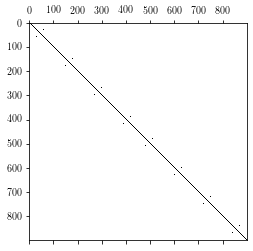

In [8]:
# Begin assembly script here.

# quasi-momentum value
#theta = np.array([0.,0.], dtype=float)
#theta = np.array([np.pi/3,0.], dtype=float)
theta = np.array([np.pi/10,np.pi/4], dtype=float)
# coupling constant at v_3
alpha3 = 0.0

logOn = False
sizeFDM = (N-1)*(N-1)
# Initalise FDM
FDM = np.zeros((sizeFDM,sizeFDM), dtype=complex)

# Assemble row entries for each region
for r in range(4):
    RegionalFDM(FDM, r+1, N, theta, log=logOn)

# Assemble row entries for each horizontal edge
for he in [23,34]:
    HorEdgeFDM(FDM, he, N, theta, log=logOn)

# Assemble row entries for each vertical edge
for ve in [31,53]:
    VerEdgeFDM(FDM, ve, N, theta, log=logOn)
    
# Assemble row entry for v_3
v3FDM(FDM, alpha3, N, log=logOn)
    
# Check sparsity pattern of FDM
plt.spy(FDM)
plt.show()

# Compute e'values and e'vectors.
# NOTE: if alpha_3 is zero, will need to insert B(N) for a generalised eigenvalue problem
# Otherwise, we can just pass FDM into eig
wVals, wVecs = eig(FDM, B(N))

/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


----- Analysis ----- 
 #E-vals found: 900
#Inf/NaN values: 2
#Real eigenvalues: 1
Reconstructed solutions: Periodic 900 / LR fail 0 / TB fail 0 / Both fail 0


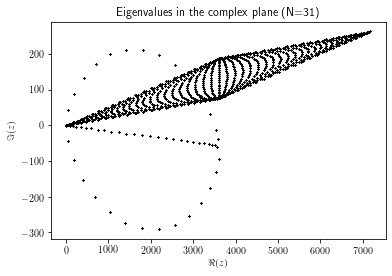

In [9]:
# reconstruct every solution and check that the result is periodic (slave boundaries have been matched correctly)
p = 0; lrFail = 0; tbFail = 0
for w in range(len(wVals)):
    wV = InsertSlaveNodes(N, wVecs[:,w], mat=True)
    tf = CheckPeriodicBCs(N, wV)
    if (tf[0] and tf[1]):
        # this solution is fine upon reconstruction
        p += 1
    elif tf[0]:
        # lr boundary fine, tb boundary not periodic
        tbFail += 1
        print('E-vec at index %d not periodic Top <-> Bottom' % (w))
    elif tf[1]:
        # tb boundary fine, lr boundary not periodic
        lrFail += 1
        print('E-vec at index %d not periodic Left <-> Right' % (w))
    else:
        # no periodicity on either solution!
        lrFail += 1
        tbFail += 1
        print('E-vec at index %d not periodic in either direction' % (w))

# visualise the eigenvalues that we found
eFig, eAx = PlotEvals(wVals)
eFig.show()
# now try this but for only the real eigenvalues?
# clear infs and NaN evals
eVals, tf = Purge(wVals)
eVecs = wVecs[:,tf]
realTF = RealEvalIndices(eVals, tol=1e-8)
#eRFig, eRAx = PlotEvals(eVals[realTF], N) #need to pass N here as otherwise the inference will be wrong!
#eRFig.show()

print('----- Analysis ----- \n #E-vals found: %d' % (len(wVals)))
print('#Inf/NaN values: %d' % (len(wVals)-len(eVals)))
print('#Real eigenvalues: %d' % (np.sum(realTF)))
print('Reconstructed solutions: Periodic %d / LR fail %d / TB fail %d / Both fail %d' %
      (p,lrFail,tbFail,lrFail+tbFail+p-len(wVals)))


Plotting with 15 contour levels


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


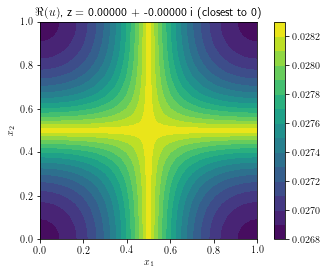

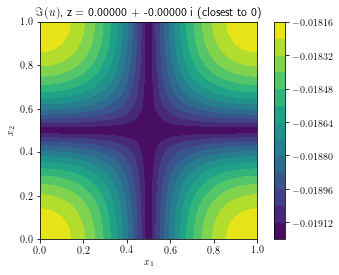

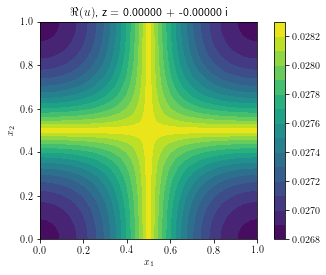

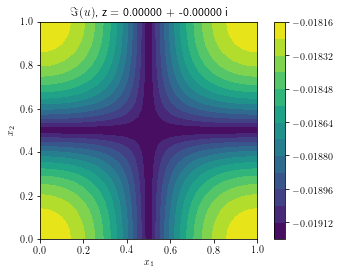

In [10]:
# close all figures that are currently open
plt.close('all')

# plot some solutions based off the eigenvalue distribution?
goodVals = eVals[realTF]
goodVecs = eVecs[:,realTF]

levels = np.min([N//2, 15])
print('Plotting with %d contour levels' % (levels))

# plot e'val closest to 0 always
minEInd = np.argmin(goodVals)
minZ = goodVals[minEInd]
rW, iW = PlotFn(N, goodVecs[:,minEInd], levels=levels)
rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i (closest to 0)' % (np.real(minZ), np.imag(minZ)))
iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i (closest to 0)' % (np.real(minZ), np.imag(minZ)))
rW[0].show()
iW[0].show()

eSelection = goodVals
if len(eSelection)<20:
    # >20 figures causes MemoryError due to pyplot interface limitations
    for i, z in enumerate(eSelection):
        rW, iW = PlotFn(N, goodVecs[:,i], levels=levels)
        rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        rW[0].show()
        iW[0].show()
else:
    # if we have more than 20 good values, randomly select 19 of them
    subSet = choice(np.arange(len(eSelection)), (19,))
    print('>20 eVals, chose to plot:', subSet)
    for i in subSet:
        z = goodVals[i]
        rW, iW = PlotFn(N, goodVecs[:,i], levels=levels)
        rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
        rW[0].show()
        iW[0].show()

>20 eVals, chose to plot: [119  16 825 293  46 328 311  44 628 891 528 709 478 214 414   3 173  19
 249]


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:49:

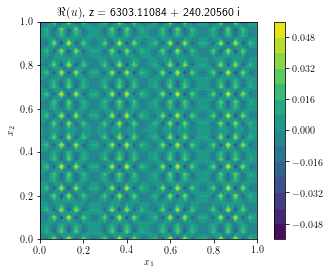

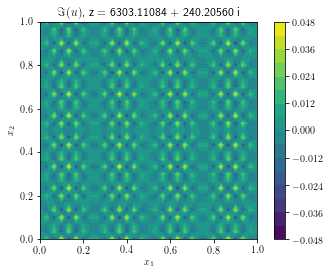

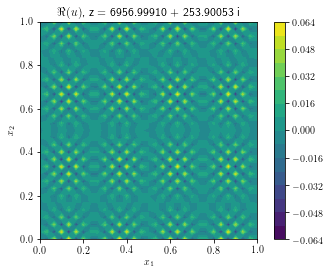

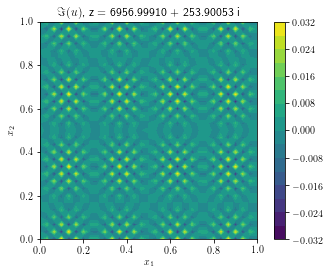

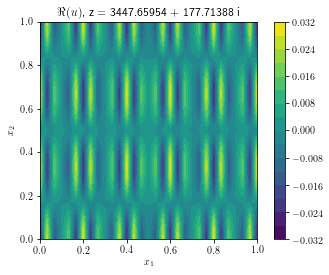

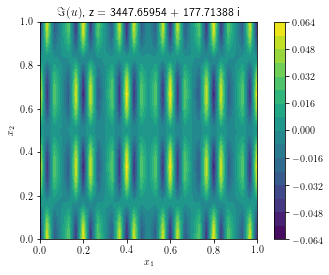

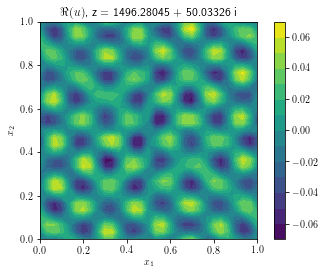

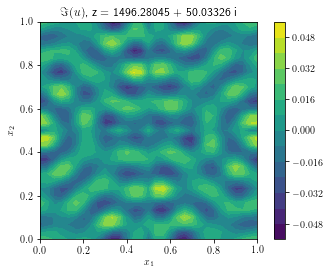

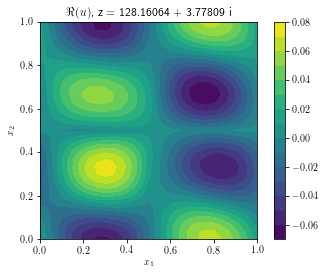

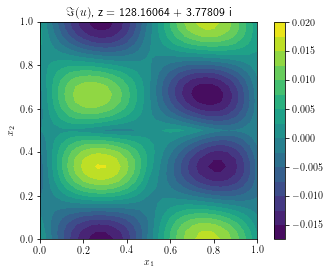

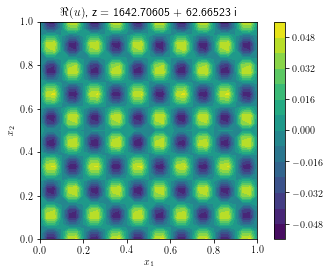

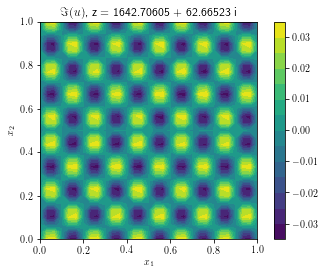

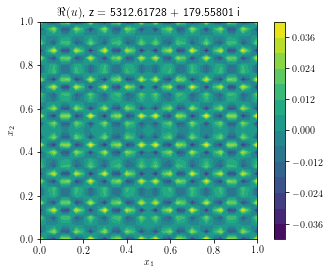

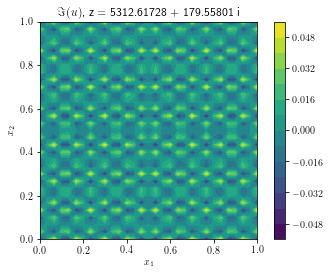

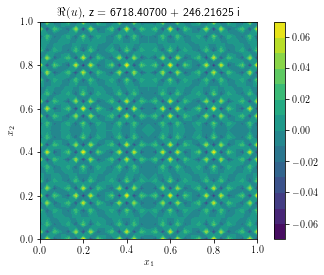

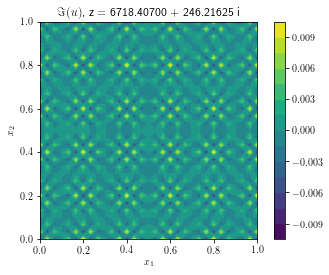

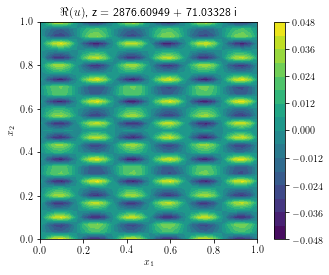

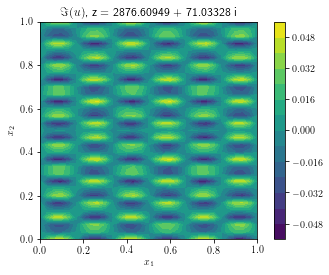

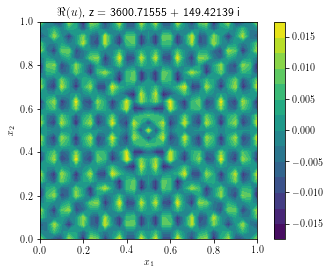

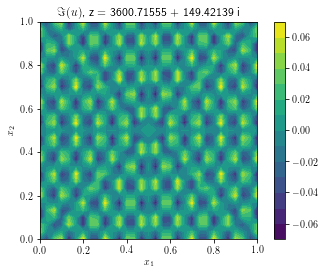

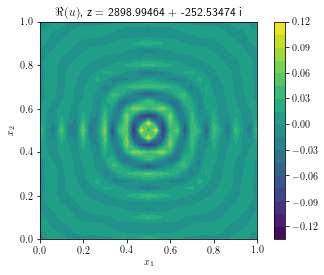

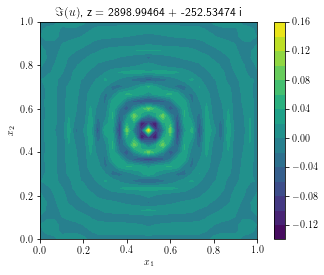

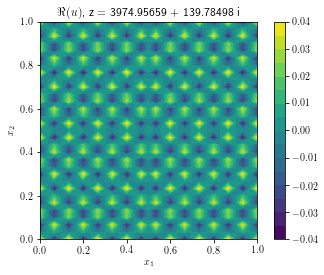

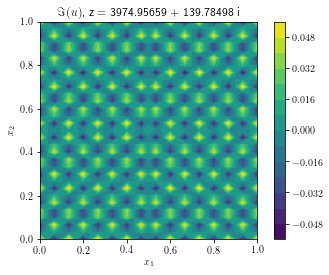

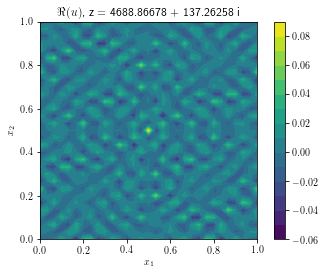

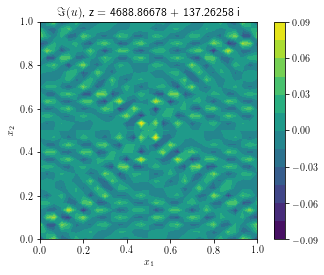

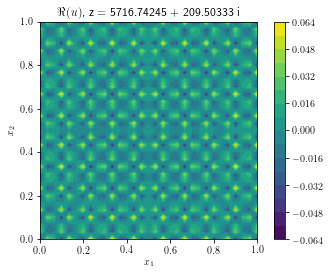

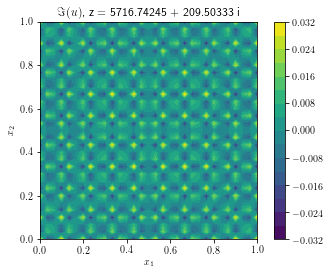

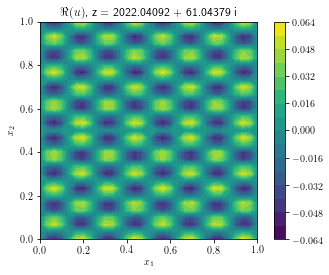

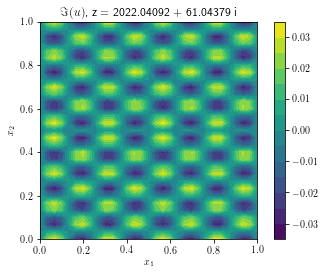

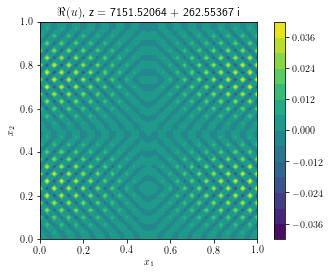

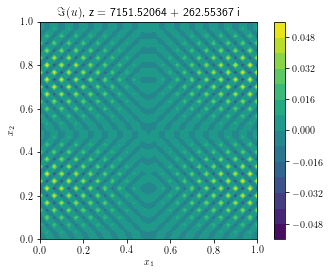

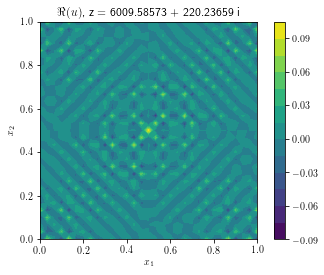

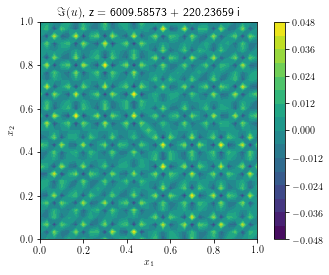

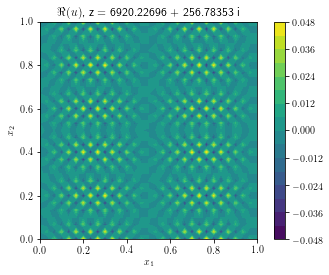

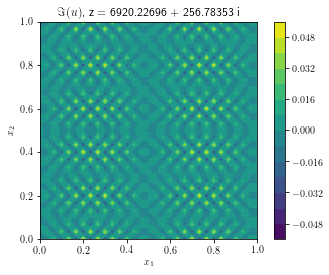

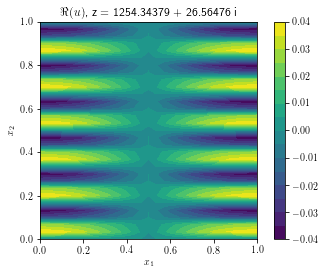

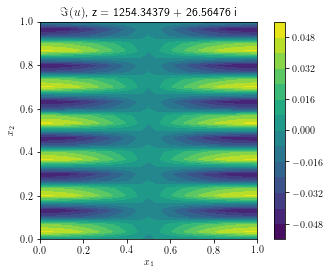

In [11]:
plt.close('all')

# plot a selection again, but this time don't restrict to only the real eigenvalues
subSet = choice(np.arange(len(eVals)), (19,))
print('>20 eVals, chose to plot:', subSet)
for i in subSet:
    z = eVals[i]
    rW, iW = PlotFn(N, eVecs[:,i], levels=levels)
    rW[1].set_title(r'$\Re(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
    iW[1].set_title(r'$\Im(u)$, z = %.5f + %.5f i' % (np.real(z), np.imag(z)))
    rW[0].show()
    iW[0].show()

In [12]:
plt.close('all')